<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Подключение и установка бибилиотек -проект выполнялся на локальном компьютере в среде Anaconda и дополнительно были установлены:

python -m spacy download en_core_web_lg

python -m spacy download en_core_web_sm

In [ ]:
#python -m spacy download en_core_web_lg
#python -m spacy download en_core_web_sm
!pip install pandarallel
!pip install spacy
!pip install catboost
#!pip install regex
!/opt/conda/bin/python -m pip install wordcloud==1.8.2.2
!pip install --upgrade Pillow

In [ ]:
import pandas as pd
import re
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import numpy as np
import torch
import transformers as ppb
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import nltk
from nltk.probability import FreqDist
from nltk import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

import spacy
from pandarallel import pandarallel
from catboost import CatBoostClassifier
from wordcloud import WordCloud

warnings.filterwarnings('ignore')
tqdm.pandas(desc="progress")
pandarallel.initialize(progress_bar = True)
nlp = spacy.load("en_core_web_sm")
stopwords = set(nltk_stopwords.words('english'))
%matplotlib inline
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...


True

Открытие файла

In [ ]:
df = pd.read_csv("/datasets/toxic_comments.csv")
df.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Колонка 0 дублирует индекс и не несет смысловой нагрузки

In [ ]:
df = df.drop(['Unnamed: 0'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Посомтрим, какое соотношение токсичных и обычных комментариев

In [ ]:
df['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

Классы несбалансированы, это нужно будет учесть либо в балансе весов, либо при подборе обучающей выборки

Проверим на наличие дубликатов

In [ ]:
df['text'].duplicated().sum()

0

Дубликаты отсутствуют

In [ ]:
lemmatizer = WordNetLemmatizer()

def clear_text(text):
    text = text.lower()
    cleared = re.sub(r'[^a-zA-Z]', ' ', text)
    return " ".join(cleared.split())

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


def lemmatize_text(text):
        lematized = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
        return  " ".join(lematized)

In [ ]:
#df['text'] = df['text'].apply(clear_text)
#df['lemm_text'] = df['text'].apply(lemmatize_text)
#df = df.drop(['text'], axis=1)
#df.to_csv('toxic_comments_lemms.csv')

In [ ]:
df.sample(10)

,text,toxic
79807,Are you Andy Greenwald? Because it'd make a lo...,1
107229,THE GODS \n\nIt's because I have sold my soul ...,0
153936,"""\nI think the existence of the tags is a text...",0
119062,"""\nSupport. This is the full RM case i made at...",0
45575,Hot 100 number-one hits of 2007 (USA)\nPlease ...,0
69699,"""\n\n Redirecting \n\nYeah, """"Prison Break"""" i...",0
32139,Fuck me in my asshole,1
65626,"""\n\n""""Alternative hip hop, like all genres of...",0
33315,.\n\n Jesus' a Jew? \nSo JEW or NOT a JEW? Se...,0
126784,"""\n\nWhich part did you find to be false? I am...",1


Очистим текст: переведем в нижний регистр, уберем все лишние символы кроме букв латинского алфавита, проведем лемматизацию.

In [ ]:
#%%time
#df['text'] = df['text'].apply(clear_text)
#df['lemm_text'] = df['text'].parallel_apply(lambda x, nlp=nlp: " ".join([token.lemma_ for token in nlp(x)]))
#df = df.drop(['text'], axis=1)
df = pd.read_csv("toxic_comments_lemms.csv")
df.sample(10)

,Unnamed: 0,toxic,lemm_text
21752,21752,0,assistance request hello again if you have som...
85882,85882,1,newsflash schuminweb be gay
138633,138633,0,removal of the ancient history and after the f...
50397,50397,0,proper use the adjustable spanner proper use s...
129409,129409,0,july utc there be a poll earlier in the year t...
99262,99262,0,i ain t do nothing wrong
58263,58263,0,utc someone should update the article to refle...
107143,107143,0,look what i just add onto the article i write ...
64782,64782,0,it s seem less and less likely that cc be first
112141,112141,0,unblock me on e now


В среде Практикума не хватает места на выполнение((  Иногда хватало, но сейчас видимо нагрузка большая. Поэтому гружу локально обработанный файл.
![image.png](attachment:image.png)

Уберем пустые строки

In [ ]:
df = df.dropna()

Посмотрим на датасет

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159281 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159281 non-null  int64 
 1   toxic       159281 non-null  int64 
 2   lemm_text   159281 non-null  object
dtypes: int64(2), object(1)
memory usage: 4.9+ MB


Проведем частотный анализ слов в текстах, признанных токсичными. Отберем только токсичные комментарии и соберем их в единый текст.

In [ ]:
toxic_array = list((df[df['toxic']>0]['lemm_text']))
corpus = " ".join(toxic_array)

Проведем токенизацию, уберем стоп-слова и отберем наиболее употребляемые

In [ ]:
tokens = word_tokenize(corpus)
tokens = [token for token in tokens if token not in stopwords]  # filter stopwords
fdist = FreqDist(tokens)
common = fdist.most_common(10)
common

[('fuck', 13527),
 ('suck', 4820),
 ('go', 4321),
 ('like', 3949),
 ('wikipedia', 3927),
 ('shit', 3721),
 ('u', 3493),
 ('nigger', 3434),
 ('get', 3379),
 ('page', 2858)]

Отобразим их на графике

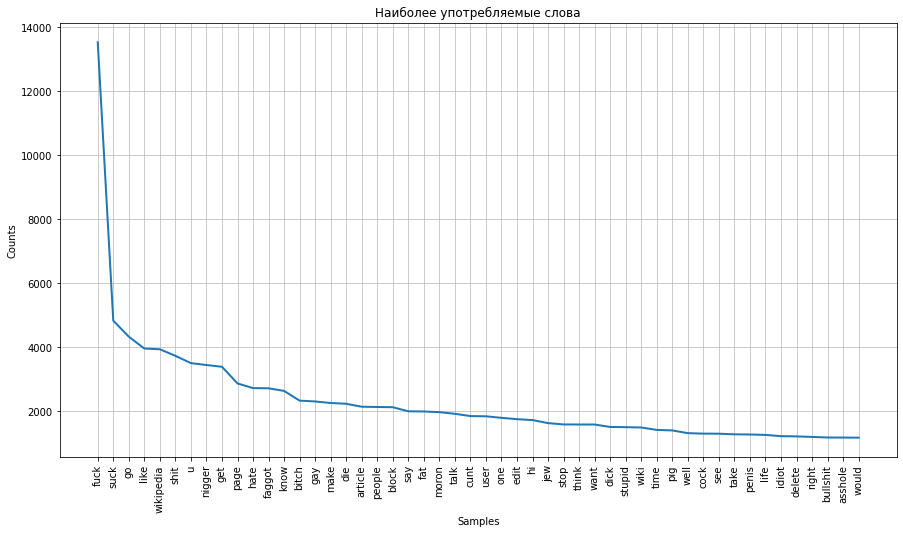

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Наиболее употребляемые слова")
fdist.plot(50,cumulative=False);

Создадим облако наиболее употребляемых слов и отобразим его

In [ ]:
wordcloud = WordCloud(collocations=False).generate(corpus)

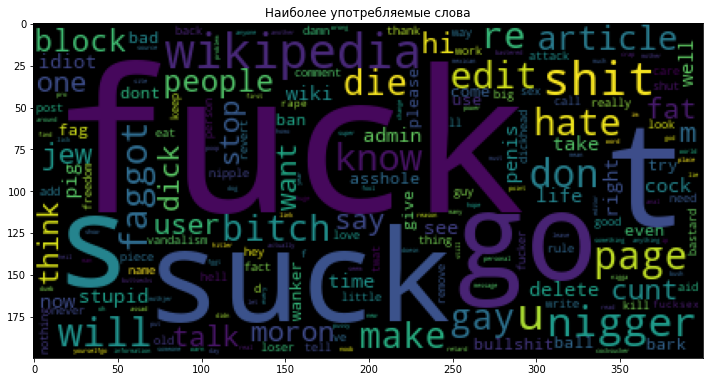

In [ ]:
plt.figure(figsize=(12,15))
plt.title("Наиболее употребляемые слова")
plt.imshow(wordcloud);

Разобьем выборку на обучающий, валидационный и тестовый наборы в соотношениии 60-20-20 с учетом стратификации выборки

In [ ]:
features = df.drop(['toxic'], axis=1)
target = df['toxic']

features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                              target,
                                                                              test_size=0.4,
                                                                              random_state=12345, stratify = target)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid,
                                                                            target_valid,
                                                                            test_size=0.5,
                                                                            random_state=12345, stratify = target_valid)

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(95568, 2)
(31856, 2)
(31857, 2)


In [ ]:
features_train.head()

,Unnamed: 0,lemm_text
104059,104059,it be list at the minor planet center a lose c...
149914,149914,warn yourself impersonate somebody else to war...
136334,136334,i don t know where you get the idea that mt ai...
3901,3901,you be a fuck head i m not a vandal so suck co...
153865,153865,yeah well i m half italian and not british


Проведем tf-idf векторизацию

In [ ]:
count_tf_idf = TfidfVectorizer(stop_words=list(stopwords))

In [ ]:
features_train_tf = count_tf_idf.fit_transform(features_train['lemm_text'].values)
features_valid_tf = count_tf_idf.transform(features_valid['lemm_text'].values)
features_test_tf = count_tf_idf.transform(features_test['lemm_text'].values)

In [ ]:
features_train.shape[0]

95568

## Обучение

### Логистическая регрессия ###

Подберем параметры для логистической регресси на обучающей выборке с tf-idf

In [ ]:
%%time
#pipe = Pipeline([
#    ('vect', CountVectorizer(ngram_range=(1,1))),
#    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
#    ('model',LogisticRegression(random_state=12345, solver='liblinear', max_iter=100))])

pipe = Pipeline([
    ('model', LogisticRegression(random_state=12345, solver='liblinear', max_iter=100))
    ])


param_grid = [
        {   'model__penalty' : ['l1', 'l2'],
            'model__C': list(range(1,10,3))
        }
]
log_grid = GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv=3, verbose=True, n_jobs=-1)
best_grid = log_grid.fit(features_train_tf, target_train) #['lemm_text'].values
print('Лучшие параметры', log_grid.best_params_)
print('Лучший результат F1:', log_grid.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Лучшие параметры {'model__C': 4, 'model__penalty': 'l1'}
Лучший результат F1: 0.7644446474456824
CPU times: user 44.1 s, sys: 36.7 s, total: 1min 20s
Wall time: 1min 20s


![image.png](attachment:image.png)

![image.png](attachment:image.png)

F1 для логистической регрессии при кросс валидации с TF IDF =  0.764

### Дерево решений ###

In [ ]:
%%time

classificator_tree = DecisionTreeClassifier(random_state=12345,
                                            class_weight = 'balanced')
parameters = {'max_depth':range(1,11,2)}
model_tree = GridSearchCV(classificator_tree, cv=3, param_grid=parameters, scoring='f1')
model_tree.fit(features_train_tf, target_train)
tree_rmse = model_tree.best_score_
print(f'Лучший RMSE :{-1*model_tree.best_score_}, лучшая модель: {model_tree.best_estimator_}')

F1 для дерева решений на валидационной выборке с TF IDF =  0.56

### Случайный лес ###

Подберем наилучшие параметры для модели

In [ ]:
%%time
classificator_tree = RandomForestClassifier(random_state=12345,
                                            class_weight = 'balanced')
parameters = {'n_estimators':range(50,100,10), 'max_depth':range(1,15,2)}
model_forest = GridSearchCV(estimator=classificator_tree, cv=3, param_grid=parameters, scoring='f1')
model_forest.fit(features_train_tf, target_train)
forest_rmse = model_forest.best_score_
print(f'Лучший RMSE :{-1*model_forest.best_score_}, лучшая модель: {model_forest.best_estimator_}')

F1 для случайного леса при кросс-валидации с TF IDF = 0.375

### CatBoost ###

Подберем наилучшие параметры для модели

In [ ]:
#%%time
#from tqdm import notebook

#model = CatBoostClassifier(learning_rate=0.4,random_state=12345,  verbose=50)
#parameters = {'n_estimators':range(60,100,10), 'depth':range(1,10,2)}

#model_cat = GridSearchCV(model, cv=3, param_grid=parameters, scoring='f1')
#notebook.tqdm(model_cat.fit(features_train_tf, target_train))
#cat_rmse= model_cat.best_score_
#print(f'Лучший RMSE :{-1*model_cat.best_score_}, лучшая модель: {model_cat.best_params_}')

Результат представлен ниже, код выполнялся свыше 8 часов.

![image.png](attachment:image.png)

In [ ]:
#%%time
#model = CatBoostClassifier(learning_rate=0.4,random_state=12345,  verbose=50, depth = 9, n_estimators = 90)
#model.fit(features_train_tf, target_train)

#cat_f1_cvs = cross_val_score(model, features_train_tf, target_train, cv=3, scoring='f1').mean()

#print('F1  при кросс валидации', cat_f1_cvs)

Значение метрики F1 при кросс-валидации для модели CatBoost с наилучшими параметрами = 0.74

Таким образом, наилучшее значение F1 на валидации показала логистическая регрессия. Применим эту модель к тестовой выборке и вычислим знаечние метрики F1:

In [ ]:
predicted_tf = log_grid.best_estimator_.predict(features_test_tf)
f1_linear_tf = f1_score(target_test, predicted_tf)
print('F1 для логистической регрессии на TF IDF = ', f1_linear_tf)

F1 для логистической регрессии на TF IDF =  0.780355630821338


Значение метрики F1 на тестовой выборке для модели логистической регрессии = 0.78

## Выводы

Таким образом, после лемматизации и вычиcления tf-idf мы подобрали наилучшие параметры для следующих моделей с целью получения максимального знаечния метрики F1:
- Логистическая регрессия
- Дерево решений
- Случайный лес
- CatBoost

В результате кросс-вавлидации были получены следующие значения метрики F1 на моделях:
- Логистическая регрессия F1 = 0.76
- Дерево решений F1 = 0.55
- Случайный лес F1 = 0.38
- CatBoost F1 =0.74

В связи с чем наиболее точной оказывается построенная модель логистической регрессии.
Применив данную модель к тестовой выборке мы получили значение метрики F1 = 0.78, что превышает требуемое знаечние в 0.75.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны